# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [23]:
# These libraries may be useful to you

#!pip install pyLDAvis  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import en_core_web_sm

from collections import Counter, defaultdict

nlp = en_core_web_sm.load()

In [40]:
# add any additional libraries you need here
import nltk
#nltk.download('brown')  #download if brown corpus is required
from nltk.corpus import stopwords
import re
stop_words = set(stopwords.words('english'))

In [3]:
# This function comes from the BTAP repo.
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [4]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [5]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [6]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<Axes: xlabel='category'>

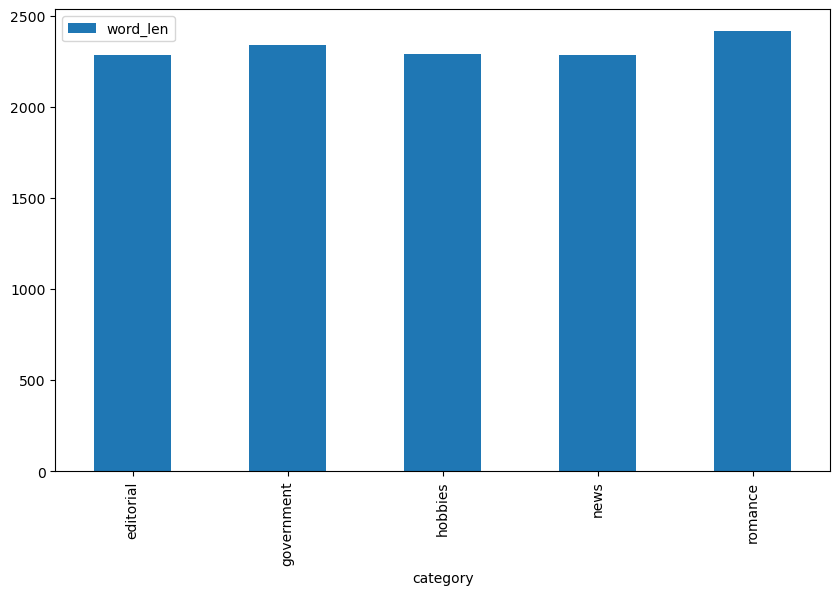

In [7]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [8]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords.words("english"), min_df=5, max_df=0.7) #updated stopwords list from nltk package
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

(166, 5073)

In [9]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords.words("english"), min_df=5, max_df=0.7) #updated stopwords list from nltk package
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 5073)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The two dataframes 'count_text_vectors' and 'tfidf_text_vectors" hold 2 different ways text can be converted to numeric vectors so that the corpus can be interpreted and used by machine learning models. 'Count_text_vectors' hold the count of words as they appear, and the 'tfidf_text_vectors' analyzes work relatives to other words in the corpus. The output represents the 166 documents across the 5 categories and 4941 words.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [10]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [11]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.48)
  president (0.43)
  kennedy (0.41)
  united (0.40)
  khrushchev (0.38)

Topic 01
  said (0.78)
  thought (0.38)
  back (0.34)
  man (0.34)
  little (0.31)

Topic 02
  mrs (2.38)
  mr (0.75)
  said (0.71)
  miss (0.48)
  car (0.46)

Topic 03
  state (0.38)
  development (0.35)
  tax (0.32)
  sales (0.29)
  may (0.28)

Topic 04
  game (0.97)
  league (0.70)
  ball (0.69)
  baseball (0.66)
  team (0.63)


Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF categorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [44]:
# Your code here - finding top words in each category of the corpus

#normalize and tokenize corpus
def tokenize(text):
    words = re.findall(r'\b\w+\b', text.lower())
    cleaned_text = [word for word in words if word not in stop_words]
    return cleaned_text

top_words_by_category = {}

for category, group in df.groupby('category'):
    all_words = []
    for text in group['text']:
        all_words.extend(tokenize(text))
    word_counts = Counter(all_words)
    top_words = word_counts.most_common(5)
    top_words_by_category[category] = top_words
    
top_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5
editorial,would,one,new,mr,american
government,state,year,states,may,1
hobbies,one,2,new,time,1
news,said,mrs,would,new,one
romance,said,would,could,one,like


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The five-topic NMP model slightly agree with the orginal brown categories.  Topic 04 aligns with hobbies, topic 00 and topic 03 could either be news or government, topic 01 aligns with editorial, and topic 02 with romance.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [13]:
# fitting an LSA model with truncatedSVD
svd_para_model = TruncatedSVD(n_components=5, random_state=314)
W_svd_para_matrix  = svd_para_model.fit_transform(tfidf_text_vectors)
H_svd_para_matrix = svd_para_model.components_

In [14]:
feature_names = tfidf_text_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(H_svd_para_matrix):
    print(f"\nTopic 0{topic_idx}:")
    top_word_indices = topic.argsort()[::-1][:5]
    top_words = [feature_names[i] for i in top_word_indices]
    print("  ".join(top_words))


Topic 00:
said  mr  mrs  state  man

Topic 01:
said  thought  back  got  looked

Topic 02:
mrs  mr  said  jr  jury

Topic 03:
khrushchev  berlin  soviet  kennedy  laos

Topic 04:
game  league  baseball  ball  team


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The five-topic LSA model agrees with the orginal categories from the Brown corpus.

In [15]:
display_topics(svd_para_model, tfidf_text_vectorizer.get_feature_names_out(), no_top_words=5)


Topic 00
  said (0.41)
  mr (0.23)
  mrs (0.20)
  state (0.19)
  man (0.16)

Topic 01
  said (3.71)
  thought (2.13)
  back (1.90)
  got (1.90)
  looked (1.76)

Topic 02
  mrs (4.51)
  mr (1.91)
  said (1.47)
  jr (0.88)
  jury (0.85)

Topic 03
  khrushchev (3.00)
  berlin (2.38)
  soviet (2.25)
  kennedy (2.25)
  laos (2.07)

Topic 04
  game (4.95)
  league (3.55)
  baseball (3.47)
  ball (3.36)
  team (3.18)


Q: What is your interpretation of the display topics output? 

A: They are slighly different from each other; the LSA model provided more detailed workd in topic 03; which looks like the government category.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [30]:
# Fit your LDA model here
lda_para_model = LatentDirichletAllocation(n_components = 5, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_text_vectors)
H_lda_para_matrix = lda_para_model.components_

In [31]:
# Call `display_topics` on your fitted model 
display_topics(lda_para_model, count_text_vectorizer.get_feature_names_out(), no_top_words=5)


Topic 00
  may (0.89)
  state (0.87)
  states (0.73)
  use (0.57)
  united (0.54)

Topic 01
  mrs (1.37)
  feed (0.70)
  per (0.49)
  house (0.44)
  pool (0.41)

Topic 02
  mr (0.60)
  president (0.51)
  american (0.44)
  world (0.42)
  united (0.40)

Topic 03
  said (1.31)
  state (0.60)
  000 (0.54)
  business (0.54)
  sales (0.44)

Topic 04
  said (1.24)
  back (0.60)
  old (0.50)
  little (0.49)
  man (0.45)


Q: What inference do you draw from the displayed topics for your LDA model? 
A: The top five words were not as defined as the LSA model.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: Not complete.

In [32]:
lda_display = pyLDAvis.lda_model.prepare(lda_para_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [33]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: There is some overlap between topic 3 and topic 4, which mean they share some common theme and terms such as government and states which could be the government and news similaries we've seen in other models.  The salient terms graph displays the most frequent terms, which for these documents were narrative words such as said and state.
